# Lab 6: Graphs II

Lab associated with Module 6: Graphs II

***

In [81]:
# The following lines are used to increase the width of cells to utilize more space on the screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

***

### Section 0: Imports

In [82]:
import numpy as np

In [83]:
import math

In [84]:
from IPython.display import Image
from graphviz import Digraph
import heapq
from collections import deque
from collections import defaultdict
import time
from time import perf_counter
import matplotlib.pyplot as plt
from IPython.display import Image
import random

Details of Digraph package: https://h1ros.github.io/posts/introduction-to-graphviz-in-jupyter-notebook/

***

### Section 1: Graph Preliminaries

Let us start by implementing our Node and Graph data structure to incorporate weights in the graph

In [85]:
class Node:
    
    def __init__(self, v):

        self.value = v
        self.inNeighbors = []
        self.outNeighbors = []
        
        #Adrian's suggestion:
        self.parent = None
        
        self.status = "unvisited"
        self.estD = np.inf
        
    def hasOutNeighbor(self, v):
        
        if v in self.outNeighbors:
            return True
        
        return False
        
    def hasInNeighbor(self, v):
        
        if v in self.inNeighbors:
            return True
        
        return False
    
    def hasNeighbor(self, v):
        
        if v in self.inNeighbors or v in self.outNeighbors:
            return True
        
        return False
    
    def getOutNeighbors(self):
        
        return self.outNeighbors
    
    def getInNeighbors(self):
        
        return self.inNeighbors
    
    def getOutNeighborsWithWeights(self):
        
        return self.outNeighbors
    
    def getInNeighborsWithWeights(self):
        
        return self.inNeighbors
    
    # ------------------------------------------------
    # Let us modify following two functions to incorporate weights
    # ------------------------------------------------
    
    def addOutNeighbor(self,v,wt):
        
        self.outNeighbors.append((v,wt))
    
    def addInNeighbor(self,v,wt):
        
        self.inNeighbors.append((v,wt))
        
        
    def __str__(self):
        
        return str(self.value) 

In [86]:
class Graph:
    
    def __init__(self):
        
        self.vertices = []

    def addVertex(self,n):
        
        self.vertices.append(n)
        
    # ------------------------------------------------
    # Let us modify following two functions to incorporate weights
    # ------------------------------------------------
        
    def addDiEdge(self, u, v, wt = 1):
        
        u.addOutNeighbor(v, wt = wt)
        v.addInNeighbor(u, wt = wt)
        
    # add edges in both directions between u and v
    def addBiEdge(self, u, v, wt = 1):
        
        self.addDiEdge(u, v, wt = wt)
        self.addDiEdge(v, u, wt = wt)
        
            
    # get a list of all the directed edges
    # directed edges are a list of two vertices
    def getDirEdges(self):
        
        ret = []
        for v in self.vertices:
            ret += [ [v, u] for u in v.outNeighbors ]
        return ret
    
    # reverse the edge between u and v.  Multiple edges are not supported.
    def reverseEdge(self,u,v):
        
        if u.hasOutNeighbor(v) and v.hasInNeighbor(u):
            
            if v.hasOutNeighbor(u) and u.hasInNeighbor(v): 
                return
        
            self.addDiEdge(v, u)
            u.outNeighbors.remove(v)
            v.inNeighbors.remove(u)        
                
    def __str__(self):
        
        ret = "Graph with:\n"
        ret += "\t Vertices:\n\t"
        for v in self.vertices:
            ret += str(v) + ","
        ret += "\n"
        ret += "\t Edges:\n\t"
        for a,b in self.getDirEdges():
            ret += "(" + str(a) + "," + str(b) + ") "
        ret += "\n"
        return ret

Now that we have incorporated the weights, let us devise a plan to generate the graph

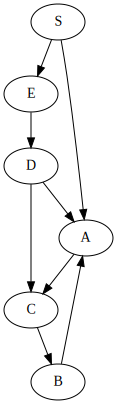

In [87]:
dot = Digraph()

dot.edge('S', 'E')
dot.edge('S', 'A')
dot.edge('E', 'D')
dot.edge('D', 'A')
dot.edge('A', 'C')
dot.edge('B', 'A')
dot.edge('D', 'C')
dot.edge('C', 'B')

#dot.view()
dot

In [88]:
G = Graph()
#for i in ['0', '1', '2', '3', '4', '5']:
for i in ['S', 'E', 'A', 'D', 'B', 'C']:
    G.addVertex( Node(i) )

In [89]:
V = G.vertices

#dot.edge('S', 'E')
G.addDiEdge( V[0], V[1], 8)

#dot.edge('S', 'A')
G.addDiEdge( V[0], V[2] , 10)

#dot.edge('E', 'D')
G.addDiEdge( V[1], V[3], 1)

#dot.edge('D', 'A')
G.addDiEdge( V[3], V[2], -4)

#dot.edge('A', 'C')
G.addDiEdge( V[2], V[5], 2)

#dot.edge('B', 'A')
G.addDiEdge( V[4], V[2], 1 )

#dot.edge('D', 'C')
G.addDiEdge( V[3], V[5], -1)

#dot.edge('C', 'B')
G.addDiEdge( V[5], V[4], -2 )

Second Example

In [90]:
G = Graph()
#for i in ['0', '1', '2', '3', '4', '5']:
for i in ['S', 'A', 'B']:
    G.addVertex(Node(i))
    
V = G.vertices

G.addDiEdge( V[0], V[1], 3)

G.addDiEdge( V[0], V[2] , 4)

G.addDiEdge( V[2], V[1], -2)

In [91]:
print(G)

Graph with:
	 Vertices:
	S,A,B,
	 Edges:
	(S,(<__main__.Node object at 0x0000015501195640>, 3)) (S,(<__main__.Node object at 0x0000015501195790>, 4)) (B,(<__main__.Node object at 0x0000015501195640>, -2)) 



***

### Section 2: Dijkstra Algorithm

In [92]:
len(G.vertices)

3

In [93]:
def dijkstra(w, G):
    
    for v in G.vertices:
        v.estD = math.inf
        v.parent = None
        
    w.estD = 0
    unsureVertices = G.vertices[:]
    
    sureVertices = []
    
    #Nayyar suggestion: parents = [None for i in len(G.vertices)] 
    #Adrian's suggestion: 
    #for i in len(G.vertices):
     #   G.vertices.index(i).parent = None
    # Jamie's solution: Keep a stack as local variable
    
    while len(unsureVertices) > 0:
    
        # find the u with the minimum estD in the dumbest way possible
        u = None
        minD = math.inf
        for x in unsureVertices:
            if x.estD < minD:
                minD = x.estD
                u = x
        
        if u == None:
            # then there is nothing more that I can reach
            return
        
        # update u's neighbors
        for v, wt in u.getOutNeighborsWithWeights():
            
            if v in sureVertices:
                continue
            
            if u.estD + wt < v.estD:
                v.estD = u.estD + wt
                
                #Nayyar's solution: parents[G.vertices.index(v)] = G.vertices.index(u)
                #Adrian's solution: 
                v.parent = u
        
        unsureVertices.remove(u)
        sureVertices.append(u)
    
    # that's it!  Now each vertex holds estD which is its distance from w

In [94]:
w = G.vertices[0]
dijkstra(w, G)

for v in G.vertices:
    print(v.value, v.estD)

S 0
A 3
B 4


In [95]:
S = w
T = None

for v in G.vertices:
    if v.value == 'B':  
        T = v
        break

if T is None:
    print("Nothing")
else:
    current = T
    path = []
    while current != S:
        path.append(current)
        current = current.parent
    
    
    path.append(S)
    path.reverse()
    print(f"from {S.value} to {T.value} path:", [node.value for node in path])
    print(f"distance: {T.estD}")


from S to B path: ['S', 'B']
distance: 4


***

### <font color='red'> Activity 1: Modify above code to do Bellman-Ford. Make sure you test for negative cycles and compare its performance with Dijkstra. </font>

In [96]:
#### TODO ####
### Good Luck ###

def Bellman_Ford(w, G):
    # Initialize distance and predecessor for all vertices
    for v in G.vertices:
        v.estD = math.inf
        v.parent = None
    
    w.estD = 0
    
    # Collect all directed edges (with weights)
    edges = []
    for v in G.vertices:
        for neighbor, wt in v.getOutNeighborsWithWeights():
            edges.append((v, neighbor, wt))
    
    # Perform |V|-1 relaxation steps
    for i in range(len(G.vertices) - 1):
        updated = False
        for u, v, wt in edges:
            if u.estD != math.inf and u.estD + wt < v.estD:
                v.estD = u.estD + wt
                v.parent = u
                updated = True
        
        if not updated:
            break
    
    # Check for negative-weight cycle
    has_negative_cycle = False
    for u, v, wt in edges:
        if u.estD != math.inf and u.estD + wt < v.estD:
            has_negative_cycle = True
            print("Negative cycle detected!")
            break
    
    return has_negative_cycle

def reconstruct_path(start, end):
    """Reconstruct path from end node to start node"""
    if end.estD == math.inf:
        return []  # Unreachable
    
    path = []
    current = end
    while current is not None:
        path.append(current)
        # Prevent infinite loop (safety check)
        if current.parent is None or current.parent in path:
            break
        current = current.parent
    
    path.reverse()
    # Ensure the path starts with the start node
    if path and path[0] != start:
        return []
    return path

# Test Bellman-Ford
print("Activity 1")

# Create Section 1 graph (6 nodes)
G_sec1 = Graph()
for i in ['S', 'E', 'A', 'D', 'B', 'C']:
    G_sec1.addVertex(Node(i))
    
V = G_sec1.vertices
G_sec1.addDiEdge(V[0], V[1], 8)   # S -> E
G_sec1.addDiEdge(V[0], V[2], 10)  # S -> A
G_sec1.addDiEdge(V[1], V[3], 1)   # E -> D
G_sec1.addDiEdge(V[3], V[2], -4)  # D -> A
G_sec1.addDiEdge(V[2], V[5], 2)   # A -> C
G_sec1.addDiEdge(V[4], V[2], 1)   # B -> A 
G_sec1.addDiEdge(V[3], V[5], -1)  # D -> C
G_sec1.addDiEdge(V[5], V[4], -2)  # C -> B 

has_negative_cycle = Bellman_Ford(V[0], G_sec1)  # Start from S
print("\nNegative cycle exists?")
print("")
print(has_negative_cycle)
print("")
print("Shortest path distances:")
for v in G_sec1.vertices:
    print(f"{v.value}: {v.estD}")

# S -> B
path = reconstruct_path(V[0], V[4])  # S -> B
print("\nS->B Path:", [node.value for node in path])

# S -> C
path = reconstruct_path(V[0], V[5])  # S -> C
print("S->C Path:", [node.value for node in path])

# S -> A
path = reconstruct_path(V[0], V[2])  # S -> A
print("S->A Path:", [node.value for node in path])


Activity 1

Negative cycle exists?

False

Shortest path distances:
S: 0
E: 8
A: 5
D: 9
B: 5
C: 7

S->B Path: ['S', 'E', 'D', 'A', 'C', 'B']
S->C Path: ['S', 'E', 'D', 'A', 'C']
S->A Path: ['S', 'E', 'D', 'A']


***

### <font color='red'> Activity 2: Implement Floyd-Warshal algorithm using above data structure (that is Node and Graph). Make sure to test all the use-cases. </font>

In [97]:
#### TODO ####
### Good Luck ###

def Floyd_Warshal(G):
    # Distance and predecessor matrices
    vertices = G.vertices
    n = len(vertices)
    
    # Create the distance matrix
    distance = np.full((n, n), np.inf)
    
    # Set diagonal 
    for i in range(n):
        distance[i][i] = 0
    
    # Create the predecessor matrix
    next_node = np.full((n, n), -1)  # Stores the index of the next hop
    
    # Create a mapping
    index_map = {v: i for i, v in enumerate(vertices)}
    
    for u in vertices:
        u_idx = index_map[u]
        for v, wt in u.getOutNeighborsWithWeights():
            v_idx = index_map[v]
            distance[u_idx][v_idx] = wt
            next_node[u_idx][v_idx] = v_idx  # Next hop is the destination node

    for k in range(n):
        for i in range(n):
            if distance[i][k] == np.inf:
                continue
            for j in range(n):
                if distance[k][j] == np.inf:
                    continue
                
                new_distance = distance[i][k] + distance[k][j]
                if new_distance < distance[i][j]:
                    distance[i][j] = new_distance
                    next_node[i][j] = next_node[i][k]  # Next hop points to the intermediate node
    
    # Negative cycles
    has_negative_cycle = False
    for i in range(n):
        if distance[i][i] < 0:
            has_negative_cycle = True
            print(f"Negative cycle detected: self-loop distance at node {vertices[i].value} is {distance[i][i]}")
            break
    
    # Path reconstruction
    def reconstruct_path(start, end):
        start_idx = index_map[start]
        end_idx = index_map[end]
        
        if distance[start_idx][end_idx] == np.inf:
            return []
        
        path = [start]
        current_idx = start_idx
        
        # Reconstruct the path 
        while current_idx != end_idx:
            next_idx_val = next_node[current_idx][end_idx]
            if next_idx_val == -1:
                break
            path.append(vertices[next_idx_val])
            current_idx = next_idx_val
        
        return path
    
    return distance, next_node, has_negative_cycle, reconstruct_path

# Test
print("Activity 2")

# Use the graph from Section 1
dist_matrix, next_node, has_neg_cycle, reconstruct_path = Floyd_Warshal(G_sec1)
print("\nDistance matrix:")
print(Floyd_Warshal(G_sec1))
print(dist_matrix)

print("\nNegative cycle exists?")
print()
print(has_neg_cycle)

graph_vertices = G_sec1.vertices

node_dict = {node.value: node for node in graph_vertices}

# S -> B
path = reconstruct_path(node_dict['S'], node_dict['B'])
print("\nPath S->B:", [node.value for node in path])

# S -> C
path = reconstruct_path(node_dict['S'], node_dict['C'])
print("Path S->C:", [node.value for node in path])

# S -> A
path = reconstruct_path(node_dict['S'], node_dict['A'])
print("Path S->A:", [node.value for node in path])

# S -> D
path = reconstruct_path(node_dict['S'], node_dict['D'])
print("Path S->D:", [node.value for node in path])

Activity 2

Distance matrix:
(array([[ 0.,  8.,  5.,  9.,  5.,  7.],
       [inf,  0., -3.,  1., -3., -1.],
       [inf, inf,  0., inf,  0.,  2.],
       [inf, inf, -4.,  0., -4., -2.],
       [inf, inf,  1., inf,  0.,  3.],
       [inf, inf, -1., inf, -2.,  0.]]), array([[-1,  1,  1,  1,  1,  1],
       [-1, -1,  3,  3,  3,  3],
       [-1, -1, -1, -1,  5,  5],
       [-1, -1,  2, -1,  2,  2],
       [-1, -1,  2, -1, -1,  2],
       [-1, -1,  4, -1,  4, -1]]), False, <function Floyd_Warshal.<locals>.reconstruct_path at 0x0000015501F7DB80>)
[[ 0.  8.  5.  9.  5.  7.]
 [inf  0. -3.  1. -3. -1.]
 [inf inf  0. inf  0.  2.]
 [inf inf -4.  0. -4. -2.]
 [inf inf  1. inf  0.  3.]
 [inf inf -1. inf -2.  0.]]

Negative cycle exists?

False

Path S->B: ['S', 'E', 'D', 'A', 'C', 'B']
Path S->C: ['S', 'E', 'D', 'A', 'C']
Path S->A: ['S', 'E', 'D', 'A']
Path S->D: ['S', 'E', 'D']


***

***

# Task 2 Graph Colouring Problem

In [98]:
def greedy_graph_coloring(graph):
    colors = {}
    for node in graph:
        # Get the set of colours used by neighbours
        neighbour_colors = {colors[neigh] for neigh in graph[node] if neigh in colors}
        # Try assigning a colour (0,1,2)
        for c in range(3):
            if c not in neighbour_colors:
                colors[node] = c
                break
        else:
            # No colour available
            colors[node] = None
    return colors


# Example usage
graph = {
    'A': ['B', 'C'],
    'B': ['A', 'C'],
    'C': ['A', 'B', 'D'],
    'D': ['C']
}
print("Greedy colouring:", greedy_graph_coloring(graph))


Greedy colouring: {'A': 0, 'B': 1, 'C': 2, 'D': 0}


# Task 3  Test if Graph is Bi-parBte

In [99]:
from collections import deque

def is_bipartite(graph):
    color = {}
    for start in graph:
        if start not in color:  # No color
            queue = deque([start])
            color[start] = 0
            while queue:
                node = queue.popleft()
                for neigh in graph[node]:
                    if neigh not in color:
                        color[neigh] = 1 - color[node]  # Mix colour
                        queue.append(neigh)
                    elif color[neigh] == color[node]:
                        return False, color
    return True, color


# test
bipartite_graph = {
    1: [2, 3],
    2: [1, 4],
    3: [1, 4],
    4: [2, 3]
}
non_bipartite_graph = {
    1: [2, 3],
    2: [1, 3],
    3: [1, 2]
}
print("Bipartite test 1:", is_bipartite(bipartite_graph))
print("Bipartite test 2:", is_bipartite(non_bipartite_graph))


Bipartite test 1: (True, {1: 0, 2: 1, 3: 1, 4: 0})
Bipartite test 2: (False, {1: 0, 2: 1, 3: 1})


# Task 6  Task 6: Research and Implement Johnson’s Algorithm

In [100]:
def dijkstra_adj(graph, start):
    "using adjacency list representation."
    dist = {node: float('inf') for node in graph}
    dist[start] = 0
    heap = [(0, start)]
    while heap:
        d, u = heapq.heappop(heap)
        if d != dist[u]:
            continue
        for v, w in graph[u].items():
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                heapq.heappush(heap, (nd, v))
    return dist

def johnson(vertices, edges):
    # Create Graph
    G_bf = Graph()
    node_map = {}
    
    # Add original vertices
    for v in vertices:
        node = Node(v)
        G_bf.addVertex(node)
        node_map[v] = node
    
    # Add auxiliary node 'Q'
    node_q = Node('Q')
    G_bf.addVertex(node_q)
    node_map['Q'] = node_q
    
    # Add original edges
    for u, v, w in edges:
        G_bf.addDiEdge(node_map[u], node_map[v], w)
    
    # Add edges from 'Q'
    for v in vertices:
        G_bf.addDiEdge(node_q, node_map[v], 0)
    
    # Bellman-Ford
    has_neg_cycle = Bellman_Ford(node_q, G_bf)
    if has_neg_cycle:
        print("Negative cycle detected. Johnson's algorithm not applicable.")
        return None
    
    # Get reweighting values
    h = {v: node_map[v].estD for v in vertices}
    
    # Build list graph
    graph_rew = {v: {} for v in vertices}
    for u, v, w in edges:
        graph_rew[u][v] = w + h[u] - h[v]  # Reweight edges
    
    # for each vertex and adjust distances
    result = {}
    for u in vertices:
        dists = dijkstra_adj(graph_rew, u)
        result[u] = {}
        for v in dists:
            result[u][v] = dists[v] - h[u] + h[v]  # Original distance
            
    return result

# Test out
V = ['A','B','C','D']
E = [('A','B',1), ('B','C',3), ('A','C',-2), ('C','D',2)]
print("Johnson result:", johnson(V, E))

Johnson result: {'A': {'A': 0, 'B': 1, 'C': -2, 'D': 0}, 'B': {'A': inf, 'B': 0, 'C': 3, 'D': 5}, 'C': {'A': inf, 'B': inf, 'C': 0, 'D': 2}, 'D': {'A': inf, 'B': inf, 'C': inf, 'D': 0}}
